# Computational Systems Biology Final Project:

## Multistate Self-Activating Genetic Toggle Switch

In [5]:
#Import packages
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

### The symmetric self-activating toggle switch

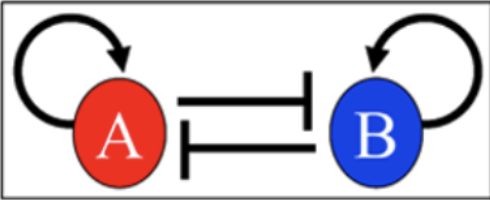

#### Hill equations
We begin with determining the dynamics of toggle switch by stating the inhibitory and excitatory hill functions that regulate the two proteins. A and B inhibit the others production while both can also self-activate themselves. This leads to the determination of 4 hill functions two that describe the dynamics for each protein. 

The regulation of A is given by:

$ H^-(B) = \large \frac{c_1}{1 + \left(\frac{B}{k_1}\right)^{n_1}}$

$ H^{+}(A) = \large \frac{c_2 \left( \frac{A}{k_2} \right)^{n_2}}{1 + \left( \frac{B}{k_2} \right)^{n_2}} $

The regulation of B is given by:

$ H^-(A) = \large \frac{c_3}{1 + \left(\frac{A}{k_3}\right)^{n_3}}$

$ H^{+}(B) = \large \frac{c_4 \left( \frac{B}{k_4} \right)^{n_4}}{1 + \left( \frac{B}{k_4} \right)^{n_4}} $

In [6]:
'''
The following functions define the hill equations for SATS. In our model, we represent a gene toggle switch where each protein 
inhibits the other while both self initiate. Thus, function, F, is an implementation of the Hill Equation and is used to compute the 
term of inhibition of either protein B inhibiting A or protein A inhibiting B. 
The funciton, F_auto, is an implementation of the Hill Equation where a protein initiates its own production (i.e. protein A initiates production of protein A).
The function, dynamics, runs the dynamical equations for protein production of A and B and returns a 2D array dydt of the rate of change of each protein. 
'''
    
def F(c, protein, k, n):
    '''
    F is the hill equation representing inhibition of one protein by a separate protein

    Parameters
    ----------
    c : float
        constant value representing synthesis rate (protein/min).
    protein : float
        represents a protein concentration of protein A.
    k : float
        constant value representing protein degradation rate (1/min). 
    n : float
        constant value representing cooperativity.

    Returns
    -------
    float
        Value described by the Hill equation.

    '''
    return c / (1+ (protein / k) ** n)



def F_auto(c, protein, n, k):
    '''
    F_auto is the hill equation representing self autoregulation of protein

    Parameters
    ----------
    c : float
        constant value representing synthesis rate (protein/min).
    protein : float
        represents a protein concentration of protein.
    n : float
        constant value representing cooperativity.
    k : float
        constant value representing protein degradation rate (1/min). 


    Returns
    -------
    float
        Value described by the Hill equation.

    '''
    return (c * protein ** n) / (k ** n + protein ** n)
 


def dynamics(y, t, c1, c2, c3, c4, n1, n2, n3, n4, k1, k2, k3, k4, alphaA, alphaB):
    '''
    The function, dynamics, finds the change in protein concentration of A and B.
    
    Parameters
    ----------
    y : array (size n = 2)
        array representing dynamics of protein B and A.
    t : array of floats
        time array.
    c1 : float
        constant value representing synthesis rate (protein/min).
    c2 : float
        constant value representing synthesis rate (protein/min).
    c3 : float
        constant value representing synthesis rate (protein/min).
    c4 : float
        constant value representing synthesis rate (protein/min).
    n1 : float
        constant value representing cooperativity.
    n2 : float
        constant value representing cooperativity.
    n3 : float
        constant value representing cooperativity.
    n4 : float
        constant value representing cooperativity.
    k1 : float
        constant value representing protein degradation rate (1/min). 
    k2 : float
        constant value representing protein degradation rate (1/min). 
    k3 : float
        constant value representing protein degradation rate (1/min). 
    k4 : float
        constant value representing protein degradation rate (1/min). 
    alphaA : TYPE
        DESCRIPTION.
    alphaB : TYPE
        DESCRIPTION.

    Returns
    -------
    dydt : 2D array of floats
        dydt[0] represents behavior of protein B and dydt[1] represents behavior of protein A.

    '''
    
    # y[1] = A
    # y[0] = B
    
    dydt = np.zeros(2)
    
    f1 = F(c1, y[1], k1, n1) # Inhibition of B by A
    f2 = F(c2, y[0], k2, n2) # Inhibition of A by B
    f3 = F_auto(c3, y[0], n3, k3) # Initiation of B by B
    f4 = F_auto(c4, y[1], n4, k4) # Initiation of A by A
    
    dydt[1] = f2 * f4 + f4 + f2- alphaA * y[1]
    dydt[0] = f1 * f3 + f1 + f3 - alphaB * y[0]
    
    return dydt


In [7]:
# Set parameters such that the system exhibits tristability
c1 = 3
c2 = 3
c3 = 3
c4 = 3

k1 = 80
k2 = 80
k3 = 40
k4 = 40

n1 = 2
n2 = 2
n3 = 8
n4 = 8

alphaA = .1
alphaB = .1


# Create two arrays to represent possible protein concentrations of A and B
A = np.arange(1, 200, 0.01 ) # Concentrations of protein A 

B = np.arange(1, 200, 0.01 ) # Concentrations of protien B

# Call F and F_auto to determine the hill equations for each protein dynamics - components of the dynamics equations
f1 = F(c1, A, k1, n1) # Inhibition of B by A
f2 = F(c2, B, k2, n2) # Inhibition of A by B
f3 = F_auto(c3, B, n3, k3) # Initiation of B  by B
f4 = F_auto(c4, A, n4, k4)  # Initiation of A by A

#### Overall transcription rate
The overall transcription rates of proteins A and B can be determined by combining the hill equations above. This toggle switch contains 2 binding sites, one for A and one for B allowing for 4 different states of binding. These states are when nothing is bound, only A is bound, only B is bound, or both A and B are bound. This provides the followning equations for the mean transcription rate of both proteins. 

$ {G_A}(A,B) = H^{+}(A) H^{-}(B) + H^{+}(A) + H^{-}(B) $

$ {G_B}(B,A) = H^{+}(B) H^{-}(A) + H^{+}(B) + H^{-}(A) $

#### Dynamics
Production is modeled with a repressor Hill function, and degradation is protein concentration dependent.

$ \large \frac{dA}{dt} = {G_A}(A,B) - \alpha_A A $

$ \large \frac{dB}{dt} = {G_B}(B,A) - \alpha_B B $

#### Nullclines

We can analyze the dynamics of this system by looking at the nullclines. Nullclines are the manifolds of the system along which the rate of change of a variable is equal to 0. This system has two nullclines, one for the rate of change of A and one for the rate of change of B. They can be found by setting the rates of change equal to zero in the above equations. 

$ \large \frac{dA}{dt} = {G_A}(A,B) - \alpha_A A = 0$ 

$ B = K_1 \large \left( \frac{-\alpha_A A + c_1 H^{+}(A) + c_1 + H^{+}(A)}{\alpha_A A - H^{+}(A)} \right) ^ \frac{1}{n_1} $

$ \large \frac{dB}{dt} = {G_B}(B,A) - \alpha_B B =0$ 

$ A = K_3 \large \left( \frac{-\alpha_B B + c_3 H^{+}(B) + c_3 + H^{+}(B)}{\alpha_B B - H^{+}(B)} \right) ^ \frac{1}{n_3} $


/var/folders/sd/yy_51k3x5232m4jjbx7n4yrr0000gn/T/ipykernel_3900/3014688947.py:2: RuntimeWarning: invalid value encountered in sqrt
  a = k1 * ((-alphaB * B + c1 * f3 + c1 + f3) / (alphaB * B - f3)) ** (1/n1)
/var/folders/sd/yy_51k3x5232m4jjbx7n4yrr0000gn/T/ipykernel_3900/3014688947.py:4: RuntimeWarning: invalid value encountered in sqrt
  b = k2 * ((-alphaA * A + c2 * f4 + c2 + f4) / (alphaA * A - f4)) ** (1/n2)


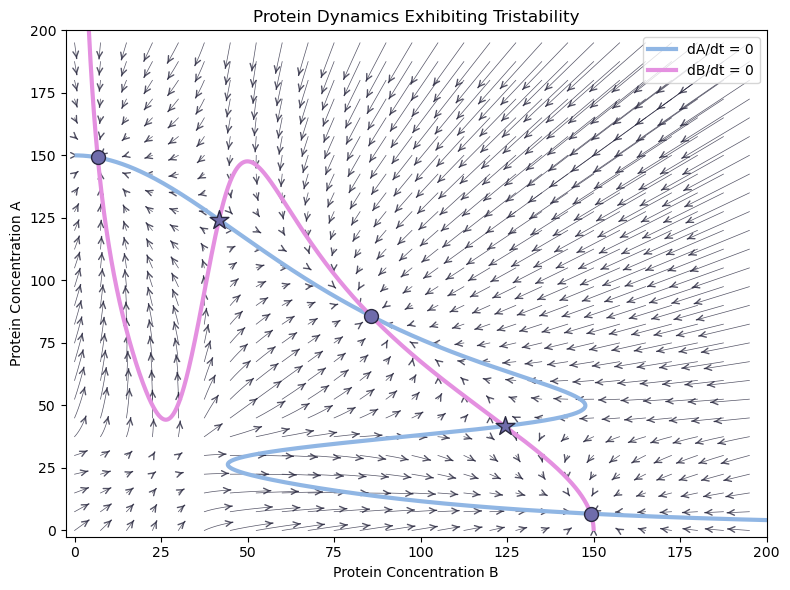

In [31]:
# Use hill equations (f1, f2, f3, f4) to determine concentrations of A and B
a = k1 * ((-alphaB * B + c1 * f3 + c1 + f3) / (alphaB * B - f3)) ** (1/n1)

b = k2 * ((-alphaA * A + c2 * f4 + c2 + f4) / (alphaA * A - f4)) ** (1/n2)

# Plot the nullclines of concentration of A agaisnt concentrations of B, marking the stable and unstable points
plt.figure(1, figsize = (8,6), clear=True)
plt.title('Protein Dynamics Exhibiting Tristability')
plt.plot(b, A, label = 'dA/dt = 0', linewidth = 3, color = '#90B6E4', zorder = 2)
plt.plot(B, a, label = 'dB/dt = 0', linewidth =3 , color = '#E490E0', zorder = 2)
plt.scatter(6.7, 149.2, zorder = 3, s = 100, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(41.8, 124.3,  zorder = 3, marker = '*', s = 200, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(85.7, 85.7,  zorder = 3, s = 100, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(124.3, 41.8,  zorder = 3, marker = '*', s = 200, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(149.2, 6.7,  zorder = 3, s = 100, color = '#6F6CAB', edgecolors = '#2A2940')
plt.legend()
plt.xlabel('Protein Concentration B')
plt.ylabel('Protein Concentration A')


# Simulate dynamics

# Create time span
t = np.linspace(0,1.5,1000)
tspan = [t[0],t[-1]]

# Use x and y arrays to create a grid of possibile initial concentrations and simulate dynamics in a loop
x = np.arange(0,200, 7.5)
y = np.arange(0,200, 7.5)
for num in x:
    for num2 in y:
        y0 = [num,num2]
        ode_sol = solve_ivp(lambda t,y:dynamics(y, t, c1, c2, c3, c4, n1, n2, n3, n4, k1, k2, k3, k4, alphaA, alphaB),tspan,y0,t_eval=t)
        plt.plot(ode_sol.y[0],ode_sol.y[1],color = '#2A2940', linewidth = .5, alpha = 0.8, zorder = 1)
        plt.annotate("" , xytext = (ode_sol.y[0][-2],ode_sol.y[1][-2]),xy=(ode_sol.y[0][-1],ode_sol.y[1][-1]), arrowprops=dict(arrowstyle="->", color = '#2A2940', alpha = 0.8),zorder = 1)

# Organize plot   
plt.xlim(-2.5,200)
plt.ylim(-2.5,200)
plt.tight_layout()
plt.savefig('SATF_Tristability')


#### Quadstability
For certain conditions this system can exhibit 4 metastable states. 

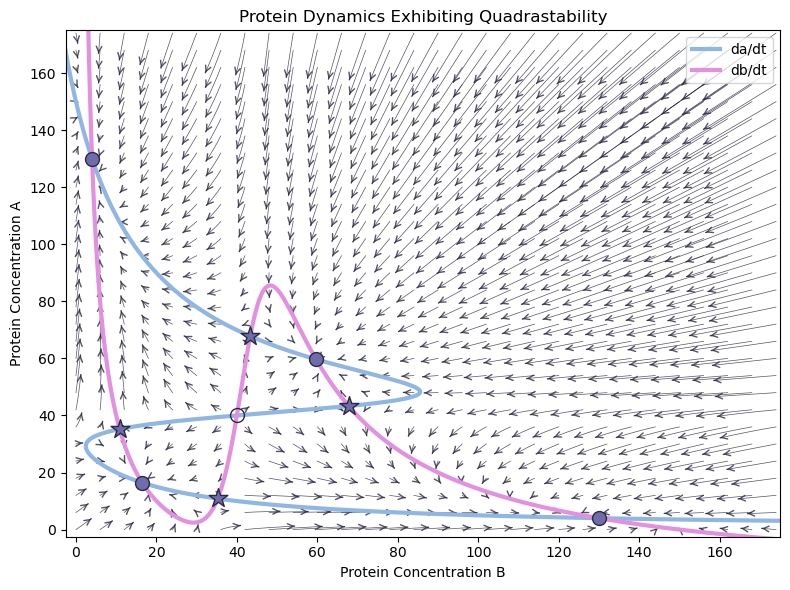

In [43]:
# Set parameters such that the system exhibits quadstability
c1 = 3
c2 = 3
c3 = 3
c4 = 3

k1 = 20
k2 = 20
k3 = 40
k4 = 40


n1 = 1
n2 = 1
n3 = 12
n4 = 12

alphaA = .1
alphaB = .1

# Create two arrays to represent possible protein concentrations of A and B
A = np.arange(1, 500, 0.01 )# Concentrations of protein A 
B = np.arange(1, 500, 0.01 )# Concentrations of protein B

# Call F and F_auto to determine the hill equations for each protein dynamics - components of the dynamics equations
f1 = F(c1, A, k1, n1) # Inhibition of B by A
f2 = F(c2, B, k2, n2) # Inhibition of A by B
f3 = F_auto(c3, B, n3, k3) # Initiation of B  by B
f4 = F_auto(c4, A, n4, k4)  # Initiation of A by A

# Use hill equations (f1, f2, f3, f4) to determine concentrations of A and B
a = k1 * ((-alphaB * B + c1 * f3 + c1 + f3) / (alphaB * B - f3)) ** (1/n1)
b = k2 * ((-alphaA * A + c2 * f4 + c2 + f4) / (alphaA * A - f4)) ** (1/n2)

# Plot the nullclines of concentration of A agaisnt concentrations of B, marking the stable and unstable points
plt.figure(2, figsize = (8,6), clear=True)
plt.title('Protein Dynamics Exhibiting Quadrastability')
plt.plot(b, A, linewidth = 3, label = 'dA/dt = 0', color = '#90B6E4', zorder = 2)
plt.plot(B, a, linewidth = 3,label = 'dB/dt = 0', color = '#E490E0', zorder = 2)
plt.scatter(4, 130, zorder = 3, s = 100, color = '#6F6CAB' , edgecolors = '#2A2940')
plt.scatter(10.9, 35.2,  zorder = 3, marker = '*', s = 200, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(16.45, 16.45, zorder = 3, s = 100, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(35.2, 10.9, zorder = 3, marker = '*', s = 200, color = '#6F6CAB', edgecolors = '#2A2940')
plt.plot(40, 40, marker = 'o', zorder = 3, ms = 10, markerfacecolor = 'None', markeredgecolor = '#2A2940')
plt.scatter(43.3, 67.8, zorder = 3, marker = '*', s = 200, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(59.7, 59.7, zorder = 3, s = 100, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(67.8, 43.3, zorder = 3, marker = '*', s = 200, color = '#6F6CAB', edgecolors = '#2A2940')
plt.scatter(130, 4,  zorder = 3, s = 100, color = '#6F6CAB', edgecolors = '#2A2940')
plt.legend()
plt.xlabel('Protein Concentration B')
plt.ylabel('Protein Concentration A')


# Simulate dynamics

# Create time span
t = np.linspace(0,1.5,1000)
tspan = [t[0],t[-1]]

# use x and y arrays to create a grid of possibile initial concentrations and simulate dynamics in a loop
x = np.arange(0,175, 6)
y = np.arange(0,175, 6)
for num in x:
    for num2 in y:
        y0 = [num,num2]
        ode_sol = solve_ivp(lambda t,y:dynamics(y, t, c1, c2, c3, c4, n1, n2, n3, n4, k1, k2, k3, k4, alphaA, alphaB),tspan,y0,t_eval=t)
        plt.plot(ode_sol.y[0],ode_sol.y[1],color = '#2A2940', linewidth = .5, alpha = 0.8, zorder = 1)
        plt.annotate("" , xytext = (ode_sol.y[0][-2],ode_sol.y[1][-2]),xy=(ode_sol.y[0][-1],ode_sol.y[1][-1]), arrowprops=dict(arrowstyle="->", color = '#2A2940', alpha = 0.8), zorder =1)

# Organize plot   
plt.xlim(-2.5,175)
plt.ylim(-2.5,175)
plt.tight_layout()
plt.savefig('SATF_Quadstability')